In [37]:
import TensorFrost as tf
import numpy as np
import matplotlib.pyplot as plt
import time

tf.initialize(tf.cpu, "/O2 /fp:fast /openmp")

resolution = 512
eps = 0.005
m_pow = 8.0
max_depth = 6.0
min_dist = 0.005

def mandelbulb(px, py, pz):
    wx, wy, wz = tf.zeros(px.shape, tf.float32), tf.zeros(px.shape, tf.float32), tf.zeros(px.shape, tf.float32)
    wx.set(px), wy.set(py), wz.set(pz)
    m = wx*wx + wy*wy + wz*wz
    dz = tf.zeros(px.shape, tf.float32)
    dz.set(1.0)
    #orbit trap
    cx, cy, cz = tf.zeros(px.shape, tf.float32), tf.zeros(px.shape, tf.float32), tf.zeros(px.shape, tf.float32)
    cx.set(tf.abs(wx)), cy.set(tf.abs(wy)), cz.set(tf.abs(wz))
    def loop_body(i):
        dz.set(m_pow * m ** (0.5*(m_pow - 1.0)) * dz + 1.0)
        r = tf.sqrt(wx*wx + wy*wy + wz*wz)
        b = m_pow * tf.acos(wy/r)
        a = m_pow * tf.atan2(wx, wz)
        c = r ** m_pow
        wx.set(px + c * tf.sin(b) * tf.sin(a))
        wy.set(py + c * tf.cos(b))
        wz.set(pz + c * tf.sin(b) * tf.cos(a))
        cx.set(tf.min(cx, tf.abs(wx)))
        cy.set(tf.min(cy, tf.abs(wy)))
        cz.set(tf.min(cz, tf.abs(wz)))
        m.set(wx*wx + wy*wy + wz*wz)
        tf.if_cond(m > 256.0, lambda: tf.break_loop())

    tf.loop(loop_body, 0, 4, 1)
    sdf = 0.25 * tf.log(m) * tf.sqrt(m) / dz
    return sdf, cx, cy, cz

def calcNormal(px, py, pz):
    sdf = mandelbulb(px, py, pz)[0]
    sdfx = mandelbulb(px + eps, py, pz)[0]
    sdfy = mandelbulb(px, py + eps, pz)[0]
    sdfz = mandelbulb(px, py, pz + eps)[0]
    nx = sdfx - sdf
    ny = sdfy - sdf
    nz = sdfz - sdf
    mag = tf.sqrt(nx*nx + ny*ny + nz*nz)
    return nx/mag, ny/mag, nz/mag

def MarchRay(shape, camx, camy, camz, dirx, diry, dirz, steps=64):
    td = tf.zeros(shape, tf.float32)
    def loop_body(k):
        px = camx + dirx * td
        py = camy + diry * td
        pz = camz + dirz * td
        sdf = mandelbulb(px, py, pz)[0]
        td.set(td + sdf)
        tf.if_cond((sdf < min_dist) | (td > max_depth), lambda: tf.break_loop())

    tf.loop(loop_body, 0, steps, 1)
    return camx + dirx * td, camy + diry * td, camz + dirz * td, td

light_dir_x = -0.577
light_dir_y = -0.577
light_dir_z = -0.577

def spherical_to_cartesian(r, theta, phi):
    # Convert spherical to Cartesian coordinates
    x = r * tf.sin(phi) * tf.cos(theta)
    y = r * tf.sin(phi) * tf.sin(theta)
    z = r * tf.cos(phi)
    return x, y, z

def cross(a, b):
    return a[1] * b[2] - a[2] * b[1], a[2] * b[0] - a[0] * b[2], a[0] * b[1] - a[1] * b[0]

def dot(a, b):
    return a[0] * b[0] + a[1] * b[1] + a[2] * b[2]

def normalize(a):
    mag = tf.sqrt(dot(a, a))
    return a[0] / mag, a[1] / mag, a[2] / mag

def mul(a, b):
    return a[0] * b, a[1] * b, a[2] * b

def add(a, b):
    return a[0] + b[0], a[1] + b[1], a[2] + b[2]

def camera_axes(r, phi, theta):
    # Camera position
    cam = spherical_to_cartesian(r, theta+1e-4, phi+1e-4)
    
    # Forward vector (normalized vector from camera position to origin)
    forward = mul(normalize(cam), -1.0)
    
    # Assuming Z is up
    world_up = 0.0, 0.0, 1.0
    
    # Right vector (cross product of world up and forward vector)
    right = cross(world_up, forward)
    right = normalize(right)
    
    # Recalculate the up vector to ensure orthogonality
    up = cross(forward, right)
    up = normalize(up)
    
    return cam, up, forward, right

def get_camera(u, v, dist, phi, theta):
    cam, up, forward, right = camera_axes(dist, phi, theta)

    dirx = forward[0] + u * right[0] + v * up[0]
    diry = forward[1] + u * right[1] + v * up[1]
    dirz = forward[2] + u * right[2] + v * up[2]

    # normalize direction
    direction = normalize((dirx, diry, dirz))

    return cam[0], cam[1], cam[2], direction[0], direction[1], direction[2]

def ray_marcher():
    camera_params = tf.input([3], tf.float32)
    camera_res = tf.input([2], tf.int32)
    N, M = camera_res[0], camera_res[1]
    canvas = tf.zeros([N, M, 3], tf.float32)
    i, j = tf.indices([N, M])
    u, v = tf.float(i), tf.float(j)
    u = (u - 0.5 * tf.float(N)) / tf.float(N)
    v = (v - 0.5 * tf.float(M)) / tf.float(M)

    camx, camy, camz, dirx, diry, dirz = get_camera(u, v, camera_params[0], camera_params[1], camera_params[2])
    
    px, py, pz, td = MarchRay(i.shape, camx, camy, camz, dirx, diry, dirz)

    def if_body():
        # Lighting
        norm = calcNormal(px, py, pz)
        sdf, m, cx, cy = mandelbulb(px, py, pz)
        r, g, b = tf.clamp(m, 0.0, 1.0), tf.clamp(cx, 0.0, 1.0), tf.clamp(cy, 0.0, 1.0)
        col = dot(norm, (light_dir_x, light_dir_y, light_dir_z)) * 0.5 + 0.5
        canvas[i, j, 0] = col * r*0.3
        canvas[i, j, 1] = col * g*0.5
        canvas[i, j, 2] = col * b*1.1

    tf.if_cond(td < max_depth, if_body)
    
    return [canvas]

raymarch = tf.compile(ray_marcher)

TensorProgram:
  Kernel count: 2
  Intermediate buffers: 0
  Lines of generated code: 876



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


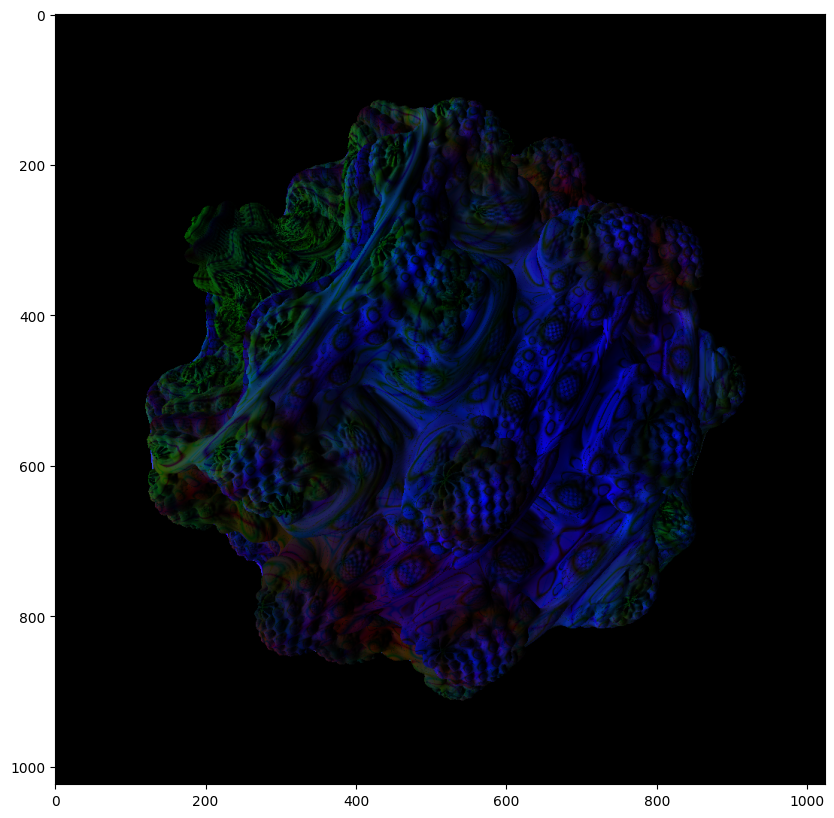

In [38]:
def render_mandelbulb(phi, theta, resolution=512):
    cam_params = tf.tensor( np.array([3.0, phi, theta], dtype=np.float32) )
    res = tf.tensor( np.array([resolution, resolution], dtype=np.int32) )

    img, = raymarch(cam_params, res)
    imgnp = img.numpy

    return imgnp

imgnp = render_mandelbulb(-0.5, 1.0, 1024)

#plot result
#set figure size
plt.figure(figsize=(10,10))
#show image
plt.imshow(imgnp)
plt.show()

In [39]:
import imageio
import os

gif_path = 'H:/TestVideos/rotating_mandelbulb.gif'

#remove file if it exists
if os.path.isfile(gif_path):
    os.remove(gif_path)

writer = imageio.get_writer(gif_path, mode='I', fps=24, loop=0)

N = 100

#go over sequence and render each frame
time_start = time.time()

for i in range(N):
    render = render_mandelbulb(-i * 1.0 * np.pi / N, np.pi/4.0, 320)
    #write to gif
    writer.append_data((np.clip(render,0.0,1.0) * 255).astype(np.uint8))
    print("Frame", i, "rendered")

time_end = time.time()

print("FPS:", N / (time_end - time_start))

writer.close()

Frame 0 rendered
Frame 1 rendered
Frame 2 rendered
Frame 3 rendered
Frame 4 rendered
Frame 5 rendered
Frame 6 rendered
Frame 7 rendered
Frame 8 rendered
Frame 9 rendered
Frame 10 rendered
Frame 11 rendered
Frame 12 rendered
Frame 13 rendered
Frame 14 rendered
Frame 15 rendered
Frame 16 rendered
Frame 17 rendered
Frame 18 rendered
Frame 19 rendered
Frame 20 rendered
Frame 21 rendered
Frame 22 rendered
Frame 23 rendered
Frame 24 rendered
Frame 25 rendered
Frame 26 rendered
Frame 27 rendered
Frame 28 rendered
Frame 29 rendered
Frame 30 rendered
Frame 31 rendered
Frame 32 rendered
Frame 33 rendered
Frame 34 rendered
Frame 35 rendered
Frame 36 rendered
Frame 37 rendered
Frame 38 rendered
Frame 39 rendered
Frame 40 rendered
Frame 41 rendered
Frame 42 rendered
Frame 43 rendered
Frame 44 rendered
Frame 45 rendered
Frame 46 rendered
Frame 47 rendered
Frame 48 rendered
Frame 49 rendered
Frame 50 rendered
Frame 51 rendered
Frame 52 rendered
Frame 53 rendered
Frame 54 rendered
Frame 55 rendered
Fr